# Polyp UNET


https://arxiv.org/pdf/1505.04597.pdf

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devikamuraly","key":"5dc62b1ba8be577aca0df221c1ae3380"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/cvcclinicdb

 92% 121M/131M [00:02<00:00, 60.3MB/s]
100% 131M/131M [00:02<00:00, 52.2MB/s]


In [ ]:
!mkdir input

In [ ]:
!unzip cvcclinicdb.zip -d input

Archive:  cvcclinicdb.zip
  inflating: input/PNG/Ground Truth/1.png  
  inflating: input/PNG/Ground Truth/10.png  
  inflating: input/PNG/Ground Truth/100.png  
  inflating: input/PNG/Ground Truth/101.png  
  inflating: input/PNG/Ground Truth/102.png  
  inflating: input/PNG/Ground Truth/103.png  
  inflating: input/PNG/Ground Truth/104.png  
  inflating: input/PNG/Ground Truth/105.png  
  inflating: input/PNG/Ground Truth/106.png  
  inflating: input/PNG/Ground Truth/107.png  
  inflating: input/PNG/Ground Truth/108.png  
  inflating: input/PNG/Ground Truth/109.png  
  inflating: input/PNG/Ground Truth/11.png  
  inflating: input/PNG/Ground Truth/110.png  
  inflating: input/PNG/Ground Truth/111.png  
  inflating: input/PNG/Ground Truth/112.png  
  inflating: input/PNG/Ground Truth/113.png  
  inflating: input/PNG/Ground Truth/114.png  
  inflating: input/PNG/Ground Truth/115.png  
  inflating: input/PNG/Ground Truth/116.png  
  inflating: input/PNG/Ground Truth/117.png  
  inflating:

In [ ]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
base_dir = './input'

images_dir ='./input/PNG/Original'
masks_dir = './input/PNG/Ground Truth'

In [ ]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [ ]:
print(len(images_listdir))
print(len(masks_listdir))

612
612


In [ ]:
image_size=512
input_image_size=(512,512)

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
number=30

# Input images

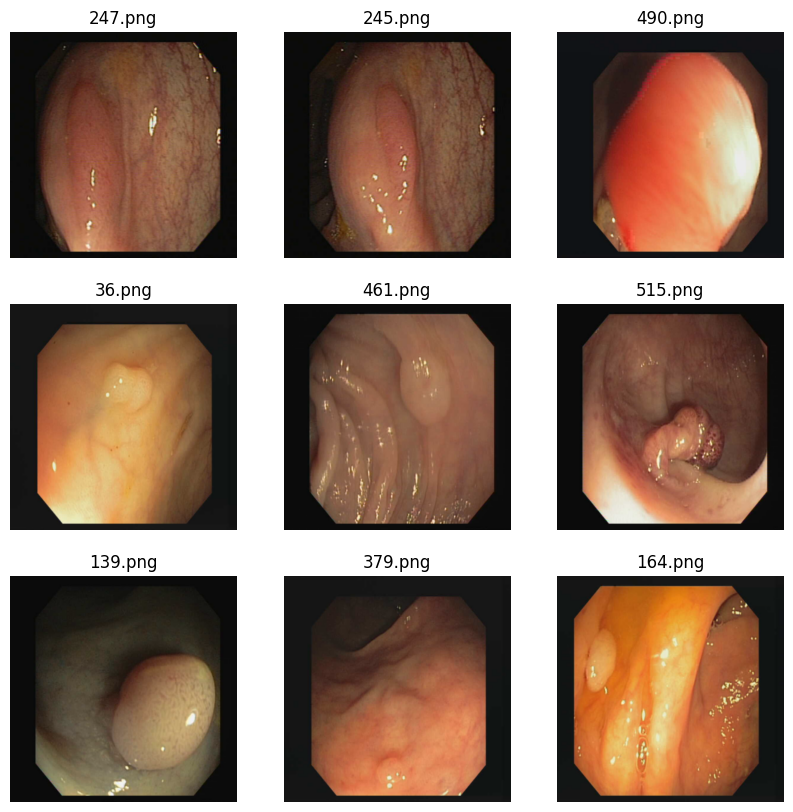

In [ ]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

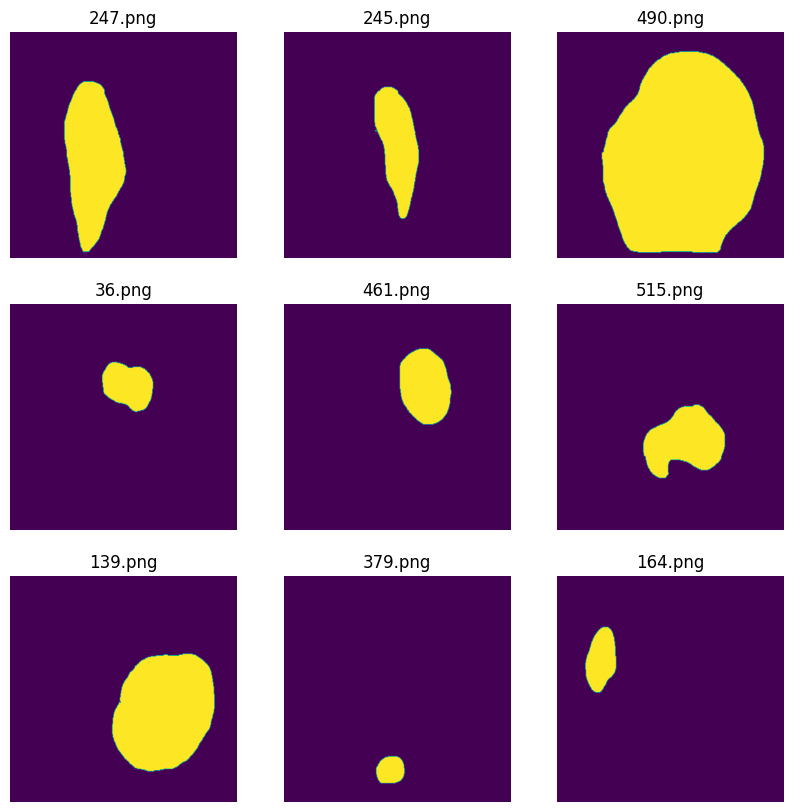

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [ ]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [ ]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(30, 512, 512, 3) (30, 512, 512, 1)


In [ ]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [ ]:
print(len(images_train), len(masks_train))

18 18


# U-Net

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

# Train

In [ ]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 10)

Epoch 1/10
4/4 [==============================] - 454s 106s/step - loss: -60.0952 - accuracy: 0.3930 - val_loss: -16007.6943 - val_accuracy: 2.0409e-04
Epoch 2/10
4/4 [==============================] - 424s 104s/step - loss: -152.6221 - accuracy: 0.5858 - val_loss: -501592.4375 - val_accuracy: 2.0409e-04
Epoch 3/10
4/4 [==============================] - 430s 107s/step - loss: -161.5504 - accuracy: 0.6765 - val_loss: -76859792.0000 - val_accuracy: 2.0409e-04
Epoch 4/10
4/4 [==============================] - 432s 107s/step - loss: -232.7414 - accuracy: 0.7259 - val_loss: -402256960.0000 - val_accuracy: 2.0409e-04
Epoch 5/10
4/4 [==============================] - 427s 105s/step - loss: -224.2711 - accuracy: 0.7039 - val_loss: -302015872.0000 - val_accuracy: 2.4796e-04
Epoch 6/10
4/4 [==============================] - 434s 108s/step - loss: -261.6388 - accuracy: 0.5023 - val_loss: -127539216.0000 - val_accuracy: 2.0409e-04
Epoch 7/10
4/4 [==============================] - 433s 108s/step - 

# Predict valid images

In [ ]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [ ]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 93s 93s/step


In [ ]:
len(images_test)

12

In [ ]:
r1,r2,r3,r4=0.6,0.8,0.9,0.99

In [ ]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

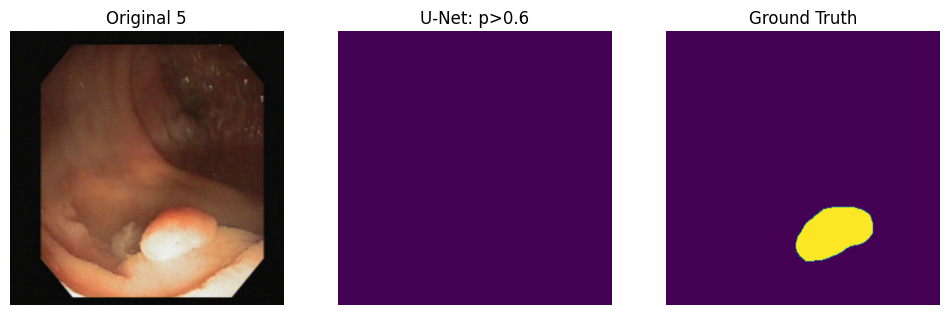

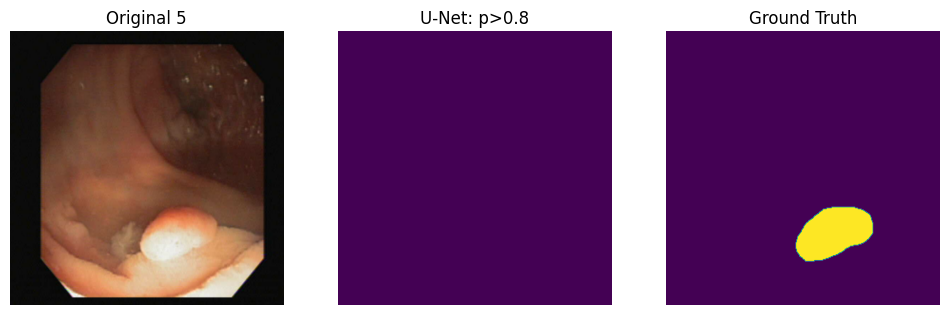

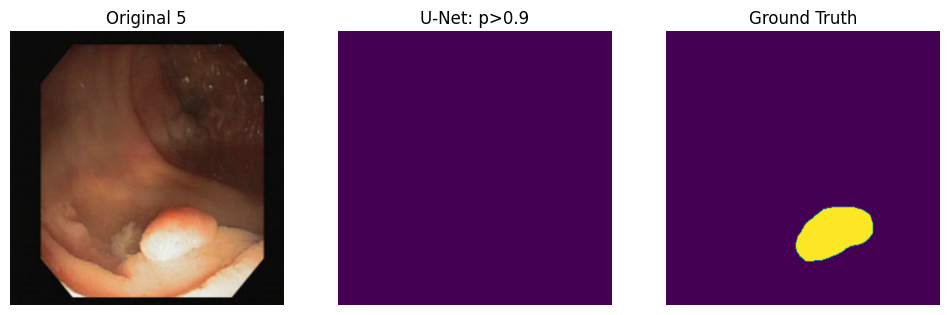

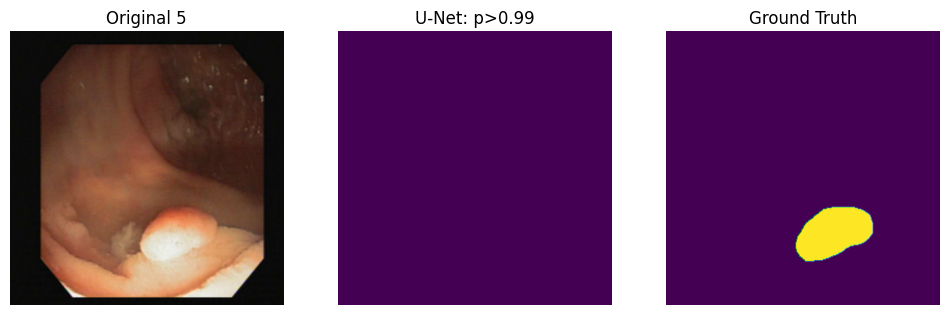

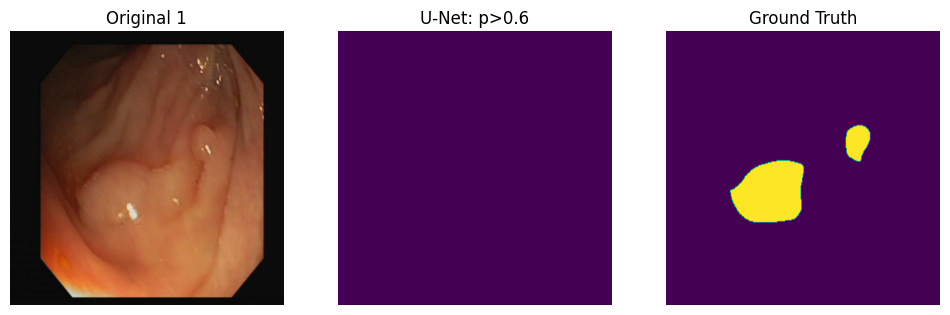

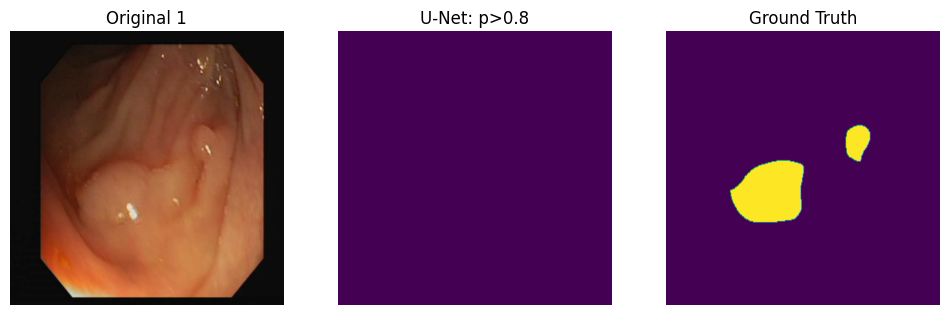

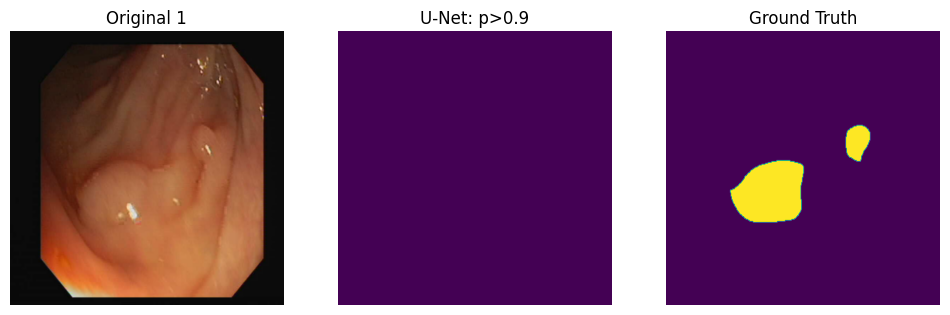

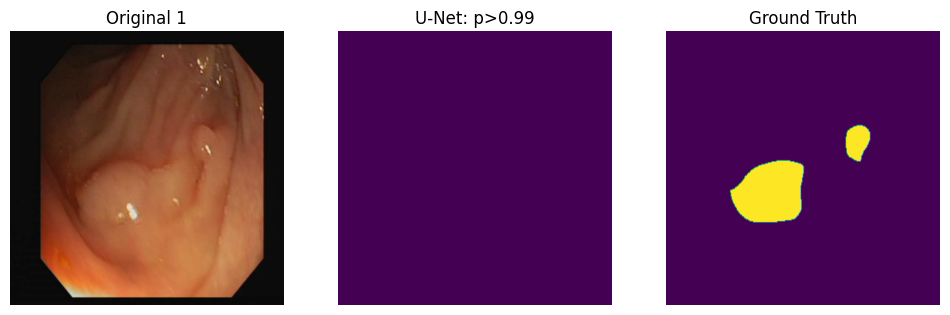

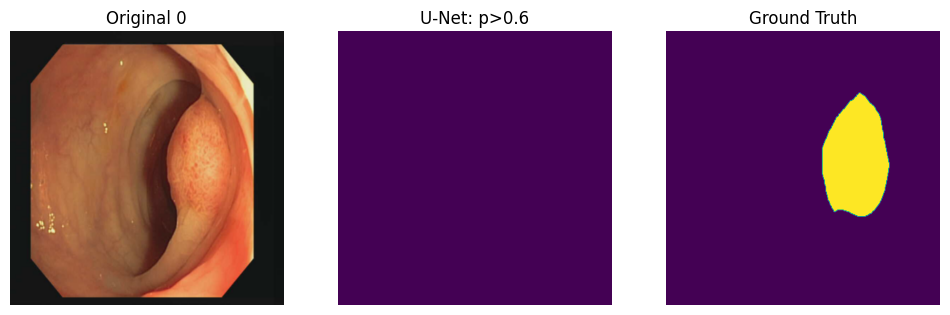

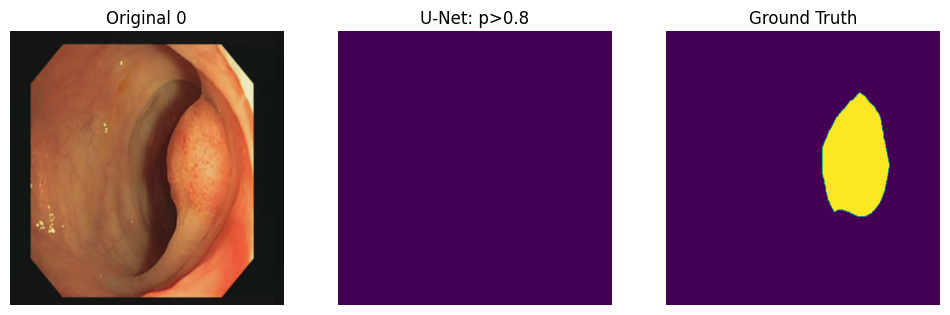

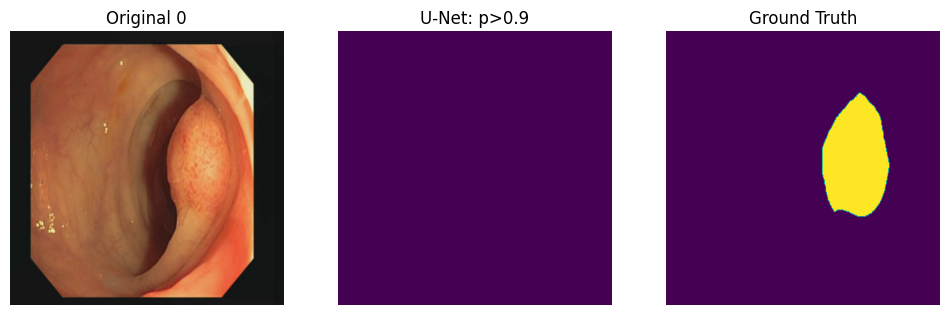

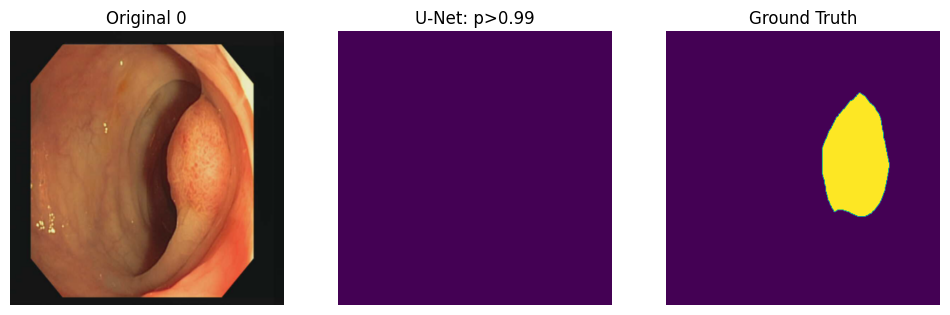

In [ ]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [ ]:

unet_model.save("unet_model.keras")




In [ ]:
from tensorflow.keras.models import load_model
unet_model = load_model("unet_model.keras")


In [ ]:
# Save the model architecture and weights
unet_model.save("unet_model.h5")
